In [1]:
import qml
import numpy as np

In [2]:
import pandas as pd

In [3]:
import local_learning

In [4]:
import pickle

In [5]:
with open('../atom_energy_coeffs.pickle', 'rb') as f:
    atom_energy_coeffs = pickle.load(f)

In [6]:
atom_energy_coeffs

{1: -0.6100284233535662,
 6: -38.01906466911168,
 7: -54.647732784759285,
 8: -75.0907686869464,
 16: -397.9423885459585}

# Learning for penicillin
Should be local models to predict large molecule from smaller ones.

In [7]:
props = pd.read_csv("../opt-amons-penicillin-target/energies.csv", names=['file', 'energy'])

In [8]:
target_energy = float(props[props['file'] == 'penicillin.xyz']['energy'])

In [9]:
target_energy

-1427.0346055

In [10]:
target_mol = qml.Compound("../opt-amons-penicillin-target/penicillin.xyz")

In [11]:
target_ncharges = target_mol.nuclear_charges
target_ncharges

array([16,  8,  8,  8,  8,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1])

In [12]:
for ncharge in target_ncharges: 
    energy_contribution = atom_energy_coeffs[ncharge]
    target_energy -= energy_contribution

In [13]:
target_energy

-0.148130310586434

In [14]:
from glob import glob

In [15]:
qm7_xyz = glob('../qm7/*.xyz')

In [16]:
qm7_mols = [qml.Compound(x) for x in qm7_xyz]

In [17]:
qm7_nuclear_charges = np.unique(np.concatenate([x.nuclear_charges for x in qm7_mols]))

In [18]:
target_mol_nuclear_charges = np.unique(target_mol.nuclear_charges)

In [19]:
target_mol_nuclear_charges

array([ 1,  6,  7,  8, 16])

In [20]:
target_rep = qml.representations.generate_fchl_acsf(target_mol.nuclear_charges, 
                                                   target_mol.coordinates, elements=target_mol_nuclear_charges)

In [21]:
qm7_ncharges = np.array([x.nuclear_charges for x in qm7_mols])

In [22]:
qm7_reps = np.array([qml.representations.generate_fchl_acsf(x.nuclear_charges, x.coordinates, 
                                                  elements=target_mol_nuclear_charges, 
                                                            pad=len(target_mol.nuclear_charges))
           for x in qm7_mols])

In [23]:
target_rep.shape

(41, 720)

In [24]:
qm7_reps.shape

(7165, 41, 720)

In [25]:
qm7_props = pd.read_csv("../qm7/energies_qm7.csv", index_col=0)

In [26]:
qm7_labels = [x.split('/')[-1].split('.xyz')[0] for x in qm7_xyz]

In [27]:
qm7_energy = np.array([float(qm7_props[qm7_props['file'] == label]['energy / Ha']) for label in qm7_labels])

In [28]:
for i, mol_ncharges in enumerate(qm7_ncharges):
    for ncharge in mol_ncharges:
        qm7_energy[i] -= atom_energy_coeffs[ncharge]

In [29]:
import matplotlib.pyplot as plt

(array([1.600e+01, 3.320e+02, 1.446e+03, 2.775e+03, 1.802e+03, 6.490e+02,
        1.210e+02, 1.800e+01, 5.000e+00, 1.000e+00]),
 array([-0.06171672, -0.03012739,  0.00146194,  0.03305128,  0.06464061,
         0.09622994,  0.12781927,  0.1594086 ,  0.19099793,  0.22258726,
         0.25417659]),
 <a list of 10 Patch objects>)

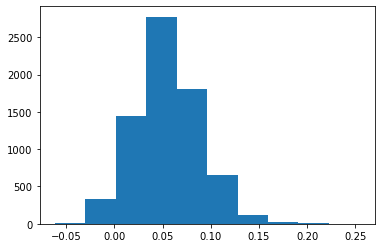

In [30]:
plt.hist(qm7_energy)

# QM7

In [22]:
import local_learning

In [23]:
sigma = 1
l2reg = 1e-10

In [24]:
train_fractions = np.logspace(-1, 0, num=5, endpoint=True)
train_sizes = [int(len(qm7_labels)*x) for x in train_fractions]

In [ ]:
lc_maes = []
for i, train_size in enumerate(train_sizes):
    X_train = qm7_reps[:train_size]
    atoms_train = qm7_ncharges[:train_size]
    y_train = qm7_energy[:train_size]
    mae, _ = local_learning.train_predict_model(X_train, atoms_train, y_train, 
                                                np.array([target_rep]), 
                                                np.array([target_mol.nuclear_charges]),
                                 np.array([target_energy]), sigma=sigma, l2reg=l2reg)
    lc_maes.append(mae)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(train_sizes, lc_maes, marker='^')

ax.set_xlabel("$N_{\mathrm{train}}$")
ax.set_ylabel("MAE")
plt.show()

In [ ]:
maes

# Opt selection

In [48]:
opt_labels = list(np.load("../fragments.npy", allow_pickle=True).tolist())

In [49]:
opt_xyz = ['../qm7/'+label+'.xyz' for label in opt_labels]

In [50]:
opt_mols = [qml.Compound(x) for x in opt_xyz]

In [52]:
opt_reps = [qml.representations.generate_fchl_acsf(x.nuclear_charges, x.coordinates, 
                                                  elements=target_mol_nuclear_charges,
                                                  pad=len(target_mol.nuclear_charges))
           for x in opt_mols]

In [53]:
opt_reps = np.array(opt_reps)

In [57]:
opt_ncharges = np.array([x.nuclear_charges for x in opt_mols])

In [54]:
opt_reps.shape

(384, 41, 720)

In [55]:
opt_energy = np.array([float(qm7_props[qm7_props['file'] == label]['energy / Ha']) for label in opt_labels])

In [56]:
opt_energy.shape

(384,)

In [59]:
sigma, l2reg = local_learning.opt_hypers(opt_reps, opt_ncharges, opt_energy, 
                          np.array([target_rep]), np.array([target_mol.nuclear_charges]),
                         np.array([target_energy]))

sigma 10 l2reg 1e-10 mae 14675.633595366675
sigma 10 l2reg 1e-07 mae 14612.48177794967
sigma 10 l2reg 0.0001 mae 9209.207963409168
sigma 100 l2reg 1e-10 mae 617519.9812151014
sigma 100 l2reg 1e-07 mae 187947.9917520971
sigma 100 l2reg 0.0001 mae 732.9356051341902
sigma 1000 l2reg 1e-10 mae 30944889.51414871
sigma 1000 l2reg 1e-07 mae 1194386.7500835739
sigma 1000 l2reg 0.0001 mae 22444.23946960078


NameError: name 'min_sigma' is not defined

# vs amons